<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/lsdd-benin_apache/benin_apache_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is based on the tutorial for [land cover classification.](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV)

Our current objective is to prepare a dataset of Benin which will be used to train a model to predict which pixels belong to a village. We wish to take in the feature collection from 'projects/ls-test-3-24/assets/voronoi_villages' which has circles around villages in Benin and use this as a target for prediction. As input, we wish to use landsat 7 imagery of Benin. We are currently running into issues creating and reading the dataset.

The notebook has the sections:


1.   Setup
2.   Define functions for dataset creation
3.   Define functions for sampling points
4.   Create pipeline and do data export
5. Read data

Sections 1-3 closely follow the tutorial notebook and appear to be working. However, sections 4 and 5 have several errors that are slowing our progress that are described in more detail in later sections of the notebook.




#dd_changenotes:
Adjusted for [weather AI notebook](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/weather-forecasting)

## 6/29
Current issue in running the pipeline locally ("EEException: Invalid number of coordinates: 1 [while running '[165]: 📑 Get example']"). Currently stack tracing to try to discover issue.
- Added `SCALE`
- Added functionality to make `get_labels_image` return label as double to match float64 of input image

## 6/30:
- Fixed visualization to reflect `get_*_image` functionality
- Removed weather-forcasting version of pipeline, replaced with original working pipeline (NumPy -> tfrecord)

# Setup

This setup section is identical to the tutorial notebook



In [1]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
%cd python-docs-samples/people-and-planet-ai/weather-forecasting

Cloning into 'python-docs-samples'...
remote: Enumerating objects: 104067, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 104067 (delta 35), reused 78 (delta 15), pack-reused 103939
Receiving objects: 100% (104067/104067), 212.82 MiB | 38.98 MiB/s, done.
Resolving deltas: 100% (61970/61970), done.
Updating files: 100% (4477/4477), done.
/content/python-docs-samples/people-and-planet-ai/weather-forecasting


In [62]:
!pip install --quiet --upgrade pip

# We need `build` and `virtualenv` to build the local packages.
!pip install --quiet build virtualenv

# Install Apache Beam and the `weather-data` local package.
!pip install apache-beam[gcp] serving/weather-data

Processing ./serving/weather-data
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for weather-data: filename=weather_data-1.0.0-py3-none-any.whl size=3901 sha256=9b0e0b03fa5ba51e15484fe779707f3762343aac3dea42f1a6a80c02ad87ca69
  Stored in directory: /root/.cache/pip/wheels/16/53/a5/9172dfb2d19e737989282de5ac7223762b586d598c1f7e195a
Successfully built weather-data
  Attempting uninstall: weather-data
    Found existing installation: weather-data 1.0.0
    Uninstalling weather-data-1.0.0:
      Successfully uninstalled weather-data-1.0.0


In [ ]:
# run to manually restart runtime by ending process
exit()

At this point runtime is restarted

In [1]:
%cd python-docs-samples/people-and-planet-ai/weather-forecasting

/content/python-docs-samples/people-and-planet-ai/weather-forecasting


In [2]:
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "ls-test-3-24" #@param {type:"string"}
bucket = "benin-bucket1" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith('gs://'), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [3]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

# Define functions for dataset creation

This section generally follows the tutorial notebook. In the end, we wish for the inputs to be LANDSAT 7 data of Benin. We select R, G, B, and NDVI bands for the input data. As labels, we wish to prepare a binary image with a target label of 1 if pixel belongs to a village and a 0 if it does not belong to a village. The village circles are specified in a feature collection available at: 'projects/ls-test-3-24/assets/voronoi_villages'

Based on our visulizations with folium at the end, this section appears to be working fine.

In [4]:
def mask_clouds_landsat(image: ee.Image) -> ee.Image:
  # Bits 3 and 5 are cloud shadow and cloud, respectively
  cloudShadowBitMask = (1 << 3) # 1000 in base 2
  cloudsBitMask = (1 << 5) # 100000 in base 2

  # Get the pixel QA band
  qa = image.select('pixel_qa')

  #Both flags should be set to zero, indicating clear conditions
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).bitwiseAnd(qa.bitwiseAnd(cloudsBitMask).eq(0))

  # Mask image with clouds and shadows
  return image.updateMask(mask)

In this next code chunk, we prepare the inputs and label images.

In [5]:
def get_inputs_image() -> ee.Image:
    opticalBands = ['B3','B2','B1'] #RGB
    thermalBands = ['B4','B3'] #NIR

    # Specify inputs (Landsat bands) to the model and the response variable.

    BANDS = ['R', 'G', 'B', 'NDVI']
    RESPONSE = 'target'

    benin = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Benin')).set('ORIG_FID',0)

    # Prepare the cloud masked LANDSAT 7 median composite image
    # clip it to the outline of Benin and then select the R,G,B, and NDVI bands.
    image = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterDate('2007-01-01', '2008-12-31')
    image = (image.map(mask_clouds_landsat).median().clip(benin.geometry().buffer(10000)))
    image_ndvi = image.normalizedDifference(thermalBands).rename(['NDVI'])
    image_rgb = image.select(opticalBands).rename(['R','G','B'])
    image = image_rgb.addBands(image_ndvi)

    return image.unmask(0)


In [6]:
def get_labels_image(as_double:bool = True) -> ee.Image:
  #Import Voronoi Raster, get treated
  treated_voronoi = ee.FeatureCollection('projects/ls-test-3-24/assets/voronoi_villages').filter(ee.Filter.eq('treated', 1))

  # Create a village mask based on the treated village raster
  villagemask = treated_voronoi.filter(ee.Filter.notNull(['VID']))\
                                        .reduceToImage(properties=['VID'],reducer= ee.Reducer.first())\
                                        .mask()

  # Create the target image using the village mask prepared earlier.
  inputs = get_inputs_image()
  l7Masked = inputs.updateMask(villagemask)
  # This part is hacky. How could we do it better?
  l7Unmasked = l7Masked.unmask(-9999)
  outside_circle = 'b("R") > -9000'
  target = l7Unmasked.expression(outside_circle).rename("target")

  if as_double: target = target.double()

  return target

## Visualize the input and target

In [11]:
#Visualize the target. White circles are inside villages, black circles are outside villages
import folium

mapid = get_labels_image().getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[9.8, 2.4], zoom_start = 7)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [13]:
# view the first three bands of the features
image = get_inputs_image()
vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["R", "G", "B"],
}
folium.Map(
    location=(9.8, 2.4),
    zoom_start=7,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [16]:
bands = image.bandNames().getInfo()
print(f"Number of bands:{len(bands)}\nBands:")
for b in bands: print(f"{b}\t", end='')

Number of bands:4
Bands:
R	G	B	NDVI	

# Define functions for sampling points

The main functions: sample_points, get_patch, get_input_patch, get_label_patch, and get_training_example are all taken from the tutorial. For our data we have the classes "in village" and "not in village", and we perform stratified sampling in these villages. Based on our visualization at the end, this section appears to be working.

** dd_NEW ** Adjust the `SCALE` here, will later be represented in `data.py`

In [17]:
from typing import Iterable
from weather import data

SCALE = 150

def sample_points(seed: int = 0, points_per_class = 2) -> Iterable[tuple[float, float]]:

    target = get_labels_image(as_double=False)
    benin = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Benin')).set('ORIG_FID',0)

    points = target.stratifiedSample(
        points_per_class,
        scale=SCALE,
        region=benin.geometry(),
        seed=seed,
        geometries=True,
    )


    for point in points.toList(points.size()).getInfo():
        yield point["geometry"]["coordinates"]


for point in sample_points():
  print(point)

[1.9046529811544155, 6.937464360434035]
[3.223828975883933, 9.919421946068788]
[2.484066339411507, 7.231213458341118]
[1.8426692265501685, 6.733995948580963]


In [18]:
import io
import numpy as np
import requests
from google.api_core import exceptions, retry

@retry.Retry(deadline=10 * 60)  # seconds
def get_patch(image: ee.Image, lonlat: tuple[float, float], patch_size: int, scale: int) -> np.ndarray:
    geometry = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL({
        "region": geometry.buffer(scale * patch_size / 2, 1).bounds(1),
        "dimensions": [patch_size, patch_size],
        "format": "NPY",
    })

    # If we get "429: Too Many Requests" errors, it's safe to retry the request.
    # The Retry library only works with `google.api_core` exceptions.
    response = requests.get(url)
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text)

    # Still raise any other exceptions to make sure we got valid data.
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

In [19]:
# overriding weather.data
from numpy.lib.recfunctions import structured_to_unstructured

def get_inputs_patch(point: tuple, patch_size: int) -> np.ndarray:
    """Gets the patch of pixels for the inputs.

    Args:
        point: A (longitude, latitude) coordinate.
        patch_size: Size in pixels of the surrounding square patch.

    Returns: The pixel values of a patch as a NumPy array.
    """
    image = get_inputs_image()
    patch = get_patch(image, point, patch_size, 30)
    return structured_to_unstructured(patch)

def get_labels_patch(point: tuple, patch_size: int) -> np.ndarray:
    """Gets the patch of pixels for the labels.

    Args:
        point: A (longitude, latitude) coordinate.
        patch_size: Size in pixels of the surrounding square patch.

    Returns: The pixel values of a patch as a NumPy array.
    """
    image = get_labels_image()
    patch = get_patch(image, point, patch_size, 30)
    return structured_to_unstructured(patch)

In [20]:
def get_training_example(lonlat, patch_size = 128):
    return (
        get_inputs_patch(lonlat, patch_size),
        get_labels_patch(lonlat, patch_size),
    )
point = [1.9046529811544155, 6.937464360434035]
target = get_labels_image(as_double=True)
(inputs, labels) = get_training_example(point, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")

inputs : float64 (128, 128, 4)
labels : float64 (128, 128, 1)


## Visualize a sampled patch

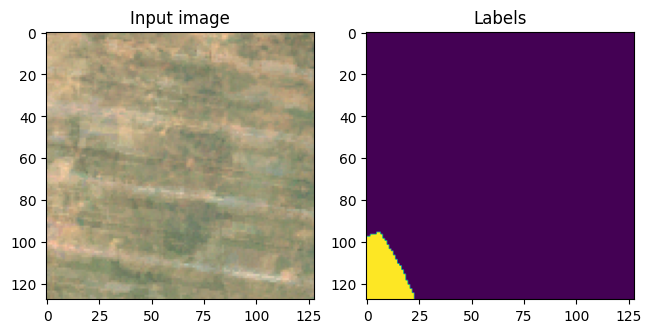

In [21]:
import matplotlib.pyplot as plt
inputs_visual = inputs[:,:, :3]
inputs_visual = inputs_visual/np.amax(inputs_visual)
fig, axs = plt.subplots(1, 2, layout='constrained')
axs[0].imshow(inputs_visual)
axs[1].imshow(labels)
axs[0].set_title("Input image")
axs[1].set_title("Labels")
plt.show()

In [22]:
print(f'Image has dtype {inputs_visual.dtype}')
print(f'Labels has dtype {labels.dtype}')

Image has dtype float64
Labels has dtype float64


# Create pipeline and do data export

This is the point in the notebook where we begin running into bugs. We attempt to follow the tutorial to use the Dataflow distributed runner to sample a certain number of tiles per class. The data export still works locally without using a distributed data runner, but we run into errors when using the distributed runner. The code is based on the create_dataset.py file, in particular the run_tensorflow function from create_dataset.py. I have attempted to follow the syntax of the example.  The code for the distributed data runner worked up to 4/27, but now (from 5/14 onwards) we are faced with the error:

`TypeError: Template.__new__() missing 1 required positional argument: 'source'`

when attempting to run the distributed data runner

## Define necessary functions for export

In [37]:
data_path = "data/"

In [42]:
PATCH_SIZE = 128
MAX_REQUESTS = 20
POINTS_PER_CLASS = 3 # small for testing purposes
beam_options = PipelineOptions([], direct_num_workers=20)

** dd_NEW ** **Note**: Find weather `run_tensorflow` as `run` in weather-forcasting/serving/weather-data/weather/data.py

## Run the pipeline locally


** dd_NEW **

1) Isssue with pipeline: `EEException: Invalid number of coordinates: 1 [while running '[165]: 📑 Get example']`

*   Currently stack tracing
*   Same issue occuring w/ [Kenya data](https://github.com/FlowAlpha/SPIRES_kenya_sensing/blob/main/apache/notebooks/2_dataset.ipynb) which imports pre-determined centroids instead of using mask strat sampling like for Benin. Suggests sample_points is generating correctly and is some other pipeline issue.
*   Issue not out of sync pipeline (set direct_num_workers=1)
*   "FIXED" by using old pipeline, not variation in weather notebook


In [41]:
# copied from create_dataset to see what the serialize_tensorflow function is doing
def serialize_tensorflow(inputs: np.ndarray, labels: np.ndarray) -> bytes:
    """Serializes inputs and labels NumPy arrays as a tf.Example.

    Both inputs and outputs are expected to be dense tensors, not dictionaries.
    We serialize both the inputs and labels to save their shapes.

    Args:
        inputs: The example inputs as dense tensors.
        labels: The example labels as dense tensors.

    Returns: The serialized tf.Example as bytes.
    """
    import tensorflow as tf

    features = {
        name: tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(data).numpy()])
        )
        for name, data in {"inputs": inputs, "labels": labels}.items()
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

In [58]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

with beam.Pipeline(options=beam_options) as pipeline:
  (
      pipeline
      | "🌱 Make seeds" >> beam.Create([0])
      | "🛰 Sample points" >> beam.FlatMap(sample_points) # uses scale of 150
      | "📖 Get examples" >> beam.Map(get_training_example)
      | "✍🏽 Serialize" >> beam.MapTuple(serialize_tensorflow)
      | "📚 Write TFRecords" >> beam.io.WriteToTFRecord(
          f"{data_path}/part", file_name_suffix=".tfrecord.gz"
      )
  )

In [47]:
!ls -lh data

total 636K
-rw-r--r-- 1 root root 635K Jun 30 19:43 part-00000-of-00001.tfrecord.gz


In [48]:
import tensorflow as tf

In [49]:
import os
current_dir = os.getcwd()
print("Current working directory:", current_dir)

Current working directory: /content/python-docs-samples/people-and-planet-ai/weather-forecasting


## Attempt to use distributed runner

**dd_NEW**: Distributed runner issue description:

Our problem might be that the distributed runner isn’t able to reference the functions it needs to. It might even be that the pickler doesn’t have support for .ipynb files and therefore can’t save the functions defined in it (why we set `save_main_session` to `True`). If you make it so that the pipeline doesn’t need to access the functions defined in __main__ (`save_main_session=False`), the runner doesn’t hit this issue, but we do get another where it explicitly can’t find the get_inputs_image function which is expected.

I’m assuming either

a) as we changed the code to reflect our needs, we changed the dependencies so that functions were unaccessible to the pipeline

and/or

b) beam just has poor python notebook support and passing up an .ipynb causes issues because it’s broken in a new version of something or it just didn’t work well to start.
tl;dr Distributed runner issue might be because it doesn’t have certain code.

The solution would be to

1.   Create a module with our functions to to “beam” up and attach it as an “extra package”
2.   Probably best to send up a script with the package instead of running it in the notebook. The weather-forcasting sample has this functionality which is helped a lot by it’s modular code structure.


In [69]:
def run_tensorflow(
    data_path: str,
    points_per_class: int = POINTS_PER_CLASS,
    patch_size: int = PATCH_SIZE,
    max_requests: int = MAX_REQUESTS,
    beam_args: Optional[List[str]] = None,
) -> None:
    """Runs an Apache Beam pipeline to create a dataset.
    This fetches data from Earth Engine and creates a TFRecords dataset.
    We use `max_requests` to limit the number of concurrent requests to Earth Engine
    to avoid quota issues. You can request for an increas of quota if you need it.
    Args:
        data_path: Directory path to save the TFRecord files.
        points_per_class: Number of points to get for each classification.
        patch_size: Size in pixels of the surrounding square patch.
        max_requests: Limit the number of concurrent requests to Earth Engine.
        polygons: List of polygons to pick points from.
        beam_args: Apache Beam command line arguments to parse as pipeline options.
    """

    beam_options = PipelineOptions(
        beam_args,
        save_main_session=True,
        max_num_workers=max_requests,  # distributed runners
        direct_num_workers=max(max_requests, MAX_REQUESTS),  # direct runner
    )
    with beam.Pipeline(options=beam_options) as pipeline:
      (
          pipeline
          | "🌱 Make seeds" >> beam.Create([0])
          | "🛰 Sample points" >> beam.FlatMap(sample_points) # uses scale of 150
          | "📖 Get examples" >> beam.Map(get_training_example)
          | "✍🏽 Serialize" >> beam.MapTuple(serialize_tensorflow)
          | "📚 Write TFRecords" >> beam.io.WriteToTFRecord(
              f"{data_path}/part", file_name_suffix=".tfrecord.gz"
          )
      )

In [50]:
data_path=f"gs://{bucket}/test_export"
print(data_path)

gs://benin-bucket1/test_export


In [70]:
# TODO: create package to "beam"
"""
# Build the package.
!python -m build {source}
!ls -lh {source}/dist
^ view the package
"""

beam_args = [
    f'--data-path="{data_path}',
    '--runner=DataflowRunner',
    f'--project={project}',
    f'--region={location}',
    f'--temp_location={data_path}/temp']
# --extra_package="./serving/weather-data/dist/weather-data-1.0.0.tar.gz"

run_tensorflow(
    data_path= data_path,
    points_per_class=points_per_class,
    patch_size=PATCH_SIZE,
    max_requests=MAX_REQUESTS,
    beam_args=beam_args,
)

TypeError: ignored

# Read data

Back when the data export seemed to work (up to 4/27) we still ran into errors reading in the data. We are currently getting the error:

`InvalidArgumentError: {{function_node wrappedIteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Type mismatch between parsed tensor (double) and dtype (float) [[{{node ParseTensor}}]] [Op:IteratorGetNext]`

It seems that there is some data type mismatch when creating the dataset. Immediately prior to dataset creation the inputs have dtype float64 and the labels have dtype uint8. It seems that in the tutorial before dataset creation the inputs and labels have the same data types, but upon reading the dataset it appears that both the inputs and labels are float32.

In [ ]:
# on 4/20, the data was written to the bucket benin_export and folder experiment_3
# using the above code (which no longer works)
bucket = 'benin_export'
folder = 'experiment_3'
data_path=f"gs://{bucket}/{folder}"
print(data_path)

gs://benin_export/experiment_3


In [ ]:
from trainer.tf_model import read_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#data_path = f"gs://example-bucket-ls-3-24/land-cover/data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

InvalidArgumentError: ignored

In [ ]:
def read_dataset(data_path: str) -> tf.data.Dataset:
    """Reads compressed TFRecord files from a directory into a tf.data.Dataset.

    Args:
        data_path: Local or Cloud Storage directory path where the TFRecord files are.

    Returns: A tf.data.Dataset with the contents of the TFRecord files.
    """
    file_pattern = tf.io.gfile.join(data_path, "*.tfrecord.gz")
    file_names = tf.data.Dataset.list_files(file_pattern).cache()
    print(file_names)
    dataset = tf.data.TFRecordDataset(file_names, compression_type="GZIP")
    return dataset.map(read_example, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
NUM_INPUTS = 4
NUM_CLASSES = 1


def read_example(serialized: bytes) -> tuple[tf.Tensor, tf.Tensor]:
    """Parses and reads a training example from TFRecords.

    Args:
        serialized: Serialized example bytes from TFRecord files.

    Returns: An (inputs, labels) pair of tensors.
    """
    features_dict = {
        "inputs": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(serialized, features_dict)
    inputs = tf.io.parse_tensor(example["inputs"], tf.float32)
    labels = tf.io.parse_tensor(example["labels"], tf.uint8)

    # TensorFlow cannot infer the shape's rank, so we set the shapes explicitly.
    inputs.set_shape([None, None, NUM_INPUTS])
    labels.set_shape([None, None, 1])

    # Classifications are measured against one-hot encoded vectors.
    one_hot_labels = tf.one_hot(labels[:, :, 0], NUM_CLASSES)
    return (inputs, one_hot_labels)


## Unfinished work

Misc. copied code chunks from the tutorial that are held up by bugs in the code above. Please ignore.

In [ ]:
#from trainer.tf_model import read_dataset
import numpy as np
import matplotlib.pyplot as plt
data_path = f"gs://example-bucket-ls-3-24/land-cover/data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

<CacheDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
inputs: float32 (128, 128, 13)
labels: float32 (128, 128, 9)


In [ ]:
data_path

'gs://benin_export/experiment_3'

In [ ]:
dataset = read_dataset(data_path)

In [ ]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [ ]:
import tensorflow as tf
print(len(tf.config.list_physical_devices('GPU')))


1


In [ ]:
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 9), dtype=tf.float32, name=None))>


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, None, 13)   27        
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 conv2d_transpose (Conv2DTra  (None, None, None, 16)   12816     
 nspose)                                                         
                                                                 
 dense (Dense)               (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


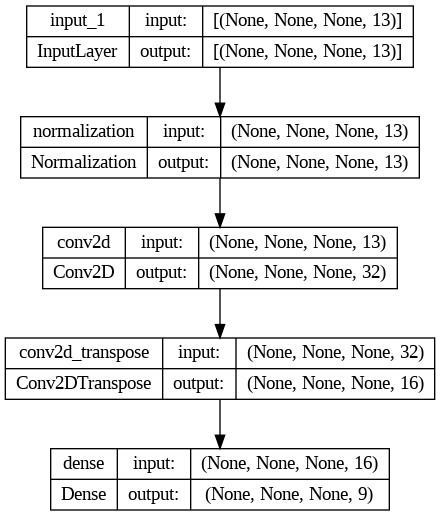

In [ ]:
from trainer.tf_model import create_model, split_dataset

(train_dataset, test_dataset) = split_dataset(dataset)
model = create_model(dataset)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Number of times to go through the training dataset.
epochs = 5

# Train the model.
model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

# Save it as files.
model.save("model")

Epoch 1/5
7/7 [==============================] - 158s 15s/step - loss: 1.9296 - one_hot_io_u: 0.1502 - val_loss: 1.6283 - val_one_hot_io_u: 0.1916
Epoch 2/5
7/7 [==============================] - 5s 614ms/step - loss: 1.5715 - one_hot_io_u: 0.2259 - val_loss: 1.4372 - val_one_hot_io_u: 0.2650
Epoch 3/5
7/7 [==============================] - 5s 747ms/step - loss: 1.4465 - one_hot_io_u: 0.2731 - val_loss: 1.3631 - val_one_hot_io_u: 0.2791
Epoch 4/5
7/7 [==============================] - 6s 765ms/step - loss: 1.3925 - one_hot_io_u: 0.2905 - val_loss: 1.3186 - val_one_hot_io_u: 0.2926
Epoch 5/5
7/7 [==============================] - 5s 617ms/step - loss: 1.3467 - one_hot_io_u: 0.2979 - val_loss: 1.2758 - val_one_hot_io_u: 0.3154


In [ ]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 365ms/step - loss: 1.2758 - one_hot_io_u: 0.3154


[1.2758320569992065, 0.315370112657547]

In [ ]:
model.predict(## whatever region you predict on)
#

In [ ]:
!pip install shapely
from google.cloud import aiplatform

epochs = 100

aiplatform.init(project=project, location=location, staging_bucket=bucket)

# https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomTrainingJob
job = aiplatform.CustomTrainingJob(
    display_name=f"land-cover",
    script_path="trainer/tf_model.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-9:latest",
)

job.run(
    machine_type='n1-highmem-8',
    accelerator_type='NVIDIA_TESLA_T4',
    accelerator_count=1,
    args=[
        f"--data-path=/gcs/{bucket}/land-cover/data",
        f"--model-path=/gcs/{bucket}/land-cover/model-large",
        f"--epochs={epochs}",
    ],
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored